In [25]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from math import exp
import functools

import torch 
from torch import nn, optim
from torch.nn import functional as F

from sklearn.model_selection import train_test_split

## General Info

`varname` + `_` means its a tensor. A normal varname would usually be a numpy array.

# Problem setting

We need to solve the Boundary Value Problem for heat dissipation in time
$$
\begin{align}
T'(t) &= r(T_{env} - T(t)) \\
% T(0) &= 25
\end{align}
$$

Our environment is a 25 degree room ($T_{env}=25$).  
The rate of change parameter $r$ is unknown and has to be learned by our network

In [26]:
def T(t):
    t = t.detach().numpy()

    return torch.tensor()


def T_diff(t, r, T_env): 
    return r*(T_env - T(t))

def cooling_law(time, T_env, T0, R):
    T = T_env + (T0 - T_env) * np.exp(-R * time)
    return T

### Data Creation

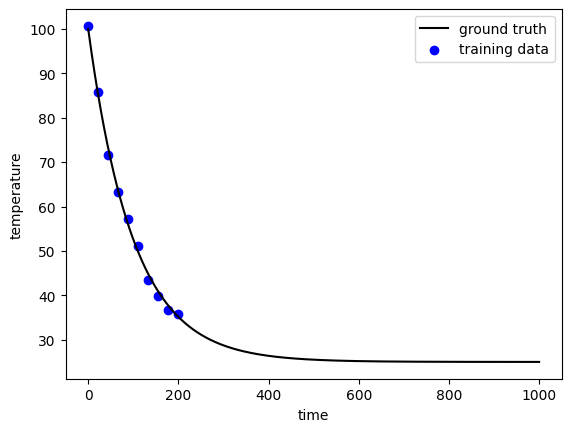

In [27]:
# Static parameters
T_env = 25
T0 = 100
R = 0.01
# making ground truth data
times = np.linspace(0, 1000, 1000)
eq = functools.partial(cooling_law, T0=T0, R=R, T_env=T_env)
temps = eq(times)
# making training data (20%) with noise
t = np.linspace(0, 200, 10)
T = eq(t) + np.random.normal(0, 1, len(t)) # variance = 1

plt.plot(times, temps, 'black', label='ground truth')
plt.scatter(t, T, c='blue', label='training data')
plt.xlabel('time')
plt.ylabel('temperature')
plt.legend()
plt.show()

# transform to tensor
t_ = torch.tensor(t).float().reshape(-1, 1).requires_grad_(True)
T_ = torch.tensor(T).float().reshape(-1, 1).requires_grad_(True)

## Network

In [28]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64, n_layers=2):
        
        super(Net, self).__init__()
        
        # model discovery parameters
        self.r = nn.Parameter(data=torch.tensor(0.), requires_grad=True) # rate of temp change. Init=0.
        
        activation = nn.ELU # nn.LeakyReLU, nn.Tanh, nn.ReLU, nn.ELU

        self.input = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), 
            activation()
        )
        
        self.network = nn.Sequential(
            *[nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                activation()
            ) for i in range(n_layers)]
        )

        self.output = nn.Sequential(
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        x = self.input(x)
        x = self.network(x)
        x = self.output(x)
        return x

In [29]:
# Helper functions

def gradient(outputs, inputs, order=1):
    """
    Computes the partial derivative of 
    an output with respect to an input.
    Given an order, we compute the gradient multiple times.
    """
    grads = []
    for i in range(order):
        grads.append(torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0])
        outputs = grads[-1]
    
    return outputs, grads

In [30]:
# losses 

def data_loss(model: torch.nn.Module, t, T):
    """
    Computes the pure data-loss
    """
    T_pred = model(t)
    return F.mse_loss(T_pred, T)

def physics_loss(model: torch.nn.Module, coll_points):
    """
    Computes the physics bounded loss given a model and 
    a number of collocation points to compute the loss on.
    """
    # collocation points
    t_col = torch.linspace(0, coll_points, coll_points).view(-1,1).requires_grad_(True)
    # run it through the model
    Temps = model(t_col)
    # compute the derivative
    T_diff, _ = gradient(Temps, t_col)
    # compute ode loss
    ode = T_diff - model.r*(T_env - Temps)

    return torch.mean(torch.square(ode))

def IC_loss(model: torch.nn.Module):


    t_0 = torch.tensor([0.]).view(-1,1).requires_grad_(True)
    IC = model(t_0)

    ode_ic = IC-100


    return torch.mean(torch.square(ode_ic))
    


## Model and training

In [31]:
from softadapt import LossWeightedSoftAdapt

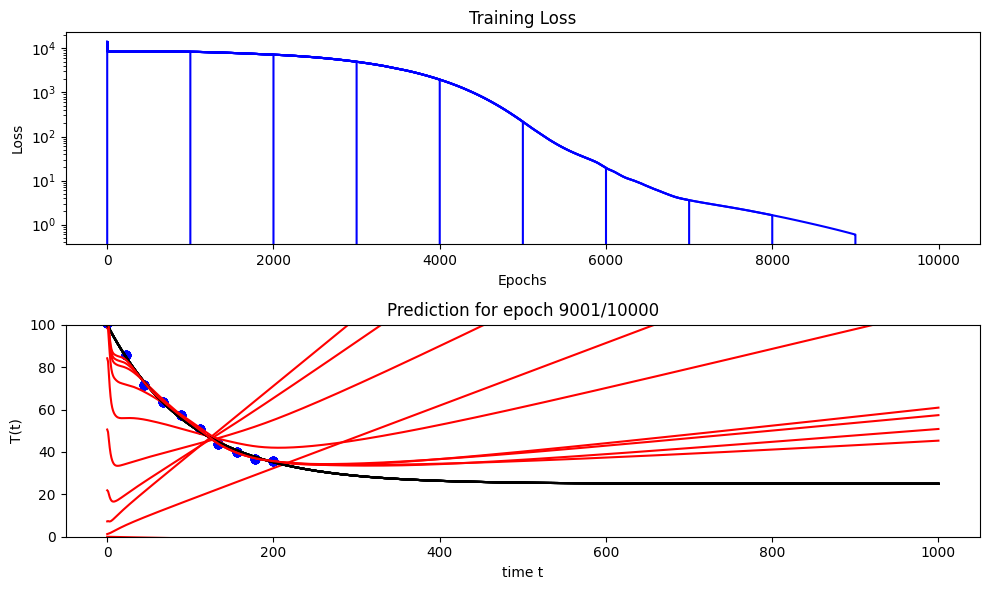

<Figure size 640x480 with 0 Axes>

In [32]:
# defining model
pinn = Net(input_dim=1, output_dim=1, hidden_dim=100, n_layers=4)
criterion = nn.MSELoss()
optimizer = optim.Adam(pinn.parameters(), lr=5e-6, weight_decay=1e-5)



""" SoftAdapt parameters """
# Change 1: Create a SoftAdapt object (with your desired variant)
softadapt_object = LossWeightedSoftAdapt(beta=0.1)

# Change 2: Define how often SoftAdapt calculate weights for the loss components
epochs_to_make_updates = 5

# Change 3: Initialize lists to keep track of loss values over the epochs we defined above
values_of_component_1 = []
values_of_component_2 = []
values_of_component_3 = []
# Initializing adaptive weights to all ones.
adapt_weights = torch.tensor([1,1,1])


### training loop
epochs = 10000

# Prepare the plot
fig, ax = plt.subplots(figsize=(10, 6), nrows=2)
losses = np.zeros(epochs)
epochs_x = np.arange(epochs)

verbose = True
pinn.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    T_pred = pinn(t_)

    # regular data driven loss
    loss_data = criterion(T_pred, T_)

    # ODE physics loss
    loss_physics = physics_loss(pinn, coll_points=1000)
    loss_ic = IC_loss(pinn)

    values_of_component_1.append(loss_data)
    values_of_component_2.append(loss_physics)
    values_of_component_3.append(loss_ic)

    
    # Change 4: Make sure `epochs_to_make_change` have passed before calling SoftAdapt.
    if epoch % epochs_to_make_updates == 0 and epoch != 0:
        adapt_weights = softadapt_object.get_component_weights(torch.tensor(values_of_component_1), 
                                                                torch.tensor(values_of_component_2), 
                                                                torch.tensor(values_of_component_3),
                                                                verbose=False,
                                                                )
                                
        # Resetting the lists to start fresh (this part is optional)
        values_of_component_1 = []
        values_of_component_2 = []
        values_of_component_3 = []
    
    # Change 5: Update the loss function with the linear combination of all components.
    loss = adapt_weights[0] * loss_data + adapt_weights[1]*loss_physics+ adapt_weights[2]*loss_ic
    

    # combined loss
    # loss = loss_data + Lam*loss_physics


    loss.backward()                 # Backward pass: Compute gradient of the loss with respect to model parameters
    optimizer.step()                # Update weights

    losses[epoch] = loss.item()
    
    if epoch % 1000 == 0 and verbose:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

        # Plotting the loss
        ax[0].plot(epochs_x, losses, 'b')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Loss')
        ax[0].set_title('Training Loss')
        ax[0].set_yscale('log')

        ### Plotting the function
        # predict full range of data
        full_T_pred = pinn(torch.tensor(times).float().reshape(-1, 1)).detach().numpy()
        # plot ground truth
        ax[1].plot(times, temps, 'k', color='black', label='Ground Truth')
        # plot data points
        ax[1].scatter(t, T, c='blue', label='Training observations')
        # plot prediction
        ax[1].plot(times, full_T_pred, 'red', label='Prediction')

        ax[1].set_xlabel('time t')
        ax[1].set_ylabel('T(t)')
        ax[1].set_title(f'Prediction for epoch {epoch+1}/{epochs}')
        ax[1].set_ylim(0, 100)
        plt.tight_layout()

        display.clear_output(wait=True)
        display.display(fig)
        
        # Pause a bit so that the plot updates
        plt.pause(0.1)


